In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf()
#set config
conf = conf.setAppName("ml_sparkSession") \
           .setMaster('local') \
           .set("spark.executor.memory", "2g") \
           .set("spark.executor.cores", "2") \
           .set("spark.sql.shuffle.partitions", "4") \
           .set("spark.executor.instances", "2") \
           .set("spark.jars.packages", "net.snowflake:spark-snowflake_2.12:2.12.0-spark_3.4")
 
#create Spark Session
spark = SparkSession.builder.config(conf = conf).getOrCreate()

In [3]:
#read data
silver_artist = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_artist")
silver_album = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_album")
silver_track = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track")
silver_track_feature = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track_feature")
#rename columns
silver_artist = silver_artist.withColumnRenamed('id', 'artist_id') \
                            .withColumnRenamed('name', 'artist_name')
#drop unnecessary columns and rename columns 
silver_album = silver_album.drop('artist', 'label', 'popularity', 'copyrights', 'url', 'link_image') \
                        .withColumnRenamed('id', 'album_id') \
                        .withColumnRenamed('name', 'album_name') \
                        .withColumnRenamed('type', 'album_type')  \
                        .withColumnRenamed('popularity', 'album_popularity')
#joining table and creating summary album table
summary_album_table = silver_artist.join(silver_album, on = 'artist_id', how = 'inner')
summary_album_table = summary_album_table.select('artist_id','artist_name','album_id','album_name',
                        'genres','followers','popularity','link_image','url','album_type',
                        'total_tracks','release_date','release_date_precision')

#joining table and creating summary track feature table
silver_track = silver_track.select('album_id', 'id', 'name', 'preview')
summary_feature_table = silver_track.join(silver_track_feature, on = 'id', how = 'left')
summary_feature_table = summary_feature_table.withColumnRenamed('id', 'track_id')

summary_table = summary_album_table.join(summary_feature_table, on = 'album_id', how = 'inner')
summary_table.cache()

24/12/09 13:29:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, total_tracks: int, release_date: date, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, mode: int, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int]

In [6]:
# summary_album_table.show()
# summary_feature_table.show()
summary_table.show(truncate= False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+------------+------------+----------------------+----------------------+--------------------------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link_image                                                      |url                                                   |album_type|total_tracks|release_date|release_date_precision|track_id              |name                                  |preview    

In [6]:
print(summary_table.columns)

['album_id', 'artist_id', 'artist_name', 'album_name', 'genres', 'followers', 'popularity', 'link_image', 'url', 'album_type', 'total_tracks', 'release_date', 'release_date_precision', 'track_id', 'name', 'preview', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


We initially drop the unwanted columns from dataFrame

In [6]:
summary_table = summary_table.drop('album_name', 'album_type', 'release_date_precision', 'time_signature')

2.303.371 size of summary table

### Exploratory Data Analysis (EDA)

- Check artist having most followers on the world

In [5]:
from pyspark.sql.functions import max

# Find the artist having most followers 
max_fl = summary_table.agg(max("followers").alias("max_fl")).collect()[0]["max_fl"]

print(max_fl)

123616624


In [6]:
from pyspark.sql.functions import col
best_playlist = summary_table.filter(col("followers") == max_fl).select("artist_name").distinct()

best_playlist.show(truncate= False)

best_playlist_list = best_playlist.rdd.flatMap(lambda x: x).collect()
print("Best Playlist:\n", best_playlist_list)

+------------+
|artist_name |
+------------+
|Arijit Singh|
+------------+



Best Playlist:
 ['Arijit Singh']


- Check which artists are featured most across all playlist for top 10 artists

/tmp/ipykernel_184/2540731308.py:18: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y = names, x = values, palette= 'pastel')


Text(0.5, 0, 'Total songs across playlists')

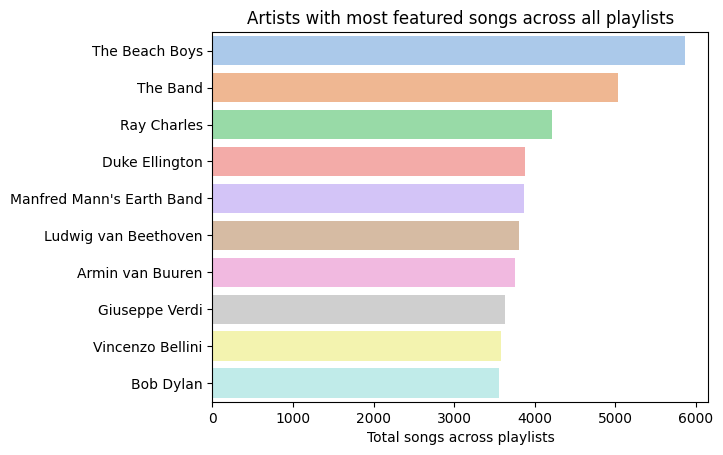

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Step 1: Group by artist_name and count the apparence
artist_counts = summary_table.groupBy("artist_name").count()

# Step 2: Sort descending by the apparence
sorted_artist_counts = artist_counts.orderBy("count", ascending = False)

# Step 3: Convert to pandas to plot data
artist_counts_pd = sorted_artist_counts.limit(10).toPandas()

# Step 4: Take the values and name of artists
values = artist_counts_pd['count'].tolist()
names = artist_counts_pd['artist_name'].tolist()

# Step 5: Plot data with seaborn
ax = sns.barplot(y = names, x = values, palette= 'pastel')
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

- Top 10 artists and music genres are most popular in the world

In [8]:
from pyspark.sql import functions as F

# Group by artist_name and calculate mean of followers 
artist_fl = summary_table.groupBy('artist_name').agg(F.mean('followers').alias('followers'))

# Sort by followers in descending order
sorted_artist_fl = artist_fl.orderBy('followers', ascending = False).limit(10)

sorted_artist_fl.show(truncate = False)

+-------------+------------+
|artist_name  |followers   |
+-------------+------------+
|Arijit Singh |1.23616624E8|
|Taylor Swift |1.22781005E8|
|Ed Sheeran   |1.16283003E8|
|Billie Eilish|1.00208733E8|
|Ariana Grande|1.00144929E8|
|Drake        |9.2294533E7 |
|The Weeknd   |9.2004576E7 |
|Eminem       |9.0916937E7 |
|Bad Bunny    |8.600057E7  |
|Justin Bieber|7.7680104E7 |
+-------------+------------+



In [9]:
# Group by genres and calculate mean of popularity
popular_genres = summary_table.groupBy('genres').agg(F.mean('popularity').alias('avg_popularity'))

# Sort by popularity in descending order
sorted_popular_genres = popular_genres.orderBy('avg_popularity', ascending = False).limit(10)

sorted_popular_genres.show(truncate = False)

+----------------------+-----------------+
|genres                |avg_popularity   |
+----------------------+-----------------+
|el paso indie         |85.0             |
|ambient pop           |85.0             |
|big room              |83.73907766990291|
|r&drill               |83.0             |
|south carolina hip hop|83.0             |
|musica tocantinense   |82.83552631578948|
|pittsburgh rap        |82.502722323049  |
|dutch edm             |82.25934579439253|
|nashville hip hop     |82.0             |
|barbadian pop         |81.34782608695652|
+----------------------+-----------------+



### Data Preprocessing

1. Check null values in each columns

In [7]:
from pyspark.sql import functions as F
# Function to check null values in each columns

def count_nulls(df):
    # Calculate null values in each columns
    null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Show results
    null_counts.show()

In [8]:
print(count_nulls(summary_table))

24/12/09 13:38:42 WARN MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 62.3 MiB so far)
24/12/09 13:38:42 WARN BlockManager: Persisting block rdd_38_3 to disk instead.


+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+------------+------------+----------------------+--------+----+-------+------------+------+------+--------+------+-----------+------------+----------------+--------+-------+------+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|total_tracks|release_date|release_date_precision|track_id|name|preview|danceability|energy|   key|loudness|  mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+------------+------------+----------------------+--------+----+-------+------------+------+------+--------+------+-----------+------------+----------------+--------+-------+------+--------------+
|       0|        0|          0|         0| 87156|        0|         0|         0|  0|         0|           0|      58737

2. Drop those columns not affect to build the model

In [9]:
tracks = summary_table.drop('release_date', 'total_tracks', 'mode')

In [10]:
print(count_nulls(tracks))

+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|release_date_precision|track_id|name|preview|danceability|energy|   key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+--------------+
|       0|        0|          0|         0| 87156|        0|         0|         0|  0|         0|                     0|       0|  52| 992106|      534770|534770|534770|  534770|     534770|      534770|          534770|

In [11]:
# Function to return shape of table
def shape(df):
    num_rows = df.count()
    nums_cols = len(df.columns)
    
    return (num_rows, nums_cols)

In [12]:
print(shape(tracks))

(2850488, 25)


Vì những cột name là tên bài hát không có nên ta sẽ bỏ những hàng không có tên bài hát đó đi vì nếu không có tên bài hát thì không thể nào recommend cho user

In [13]:
tracks = tracks.dropna(subset = ['name'])
print(shape(tracks))

(2850436, 25)


Vì những cột features như là danceability, energy, acousticness, valence, tempo là những features quan trọng cho việc phân loại theo cảm xúc nên nếu là null values ta sẽ loại bỏ hết những hàng đó

In [14]:
# List of columns need to be dropped
cols_to_drop = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Drop those columns above
tracks = tracks.dropna(subset = cols_to_drop)
print(shape(tracks))

(2315666, 25)


In [15]:
print(count_nulls(tracks))

+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|release_date_precision|track_id|name|preview|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0|         0| 81748|        0|         0|         0|  0|         0|                     0|       0|   0| 525853|           0|     0|  0|       0|          0|           0|               0|       0|      

In [16]:
print(tracks.select('track_id').distinct().count())

903635


### Build Recommendation System

#### 1/ Recommend songs by name of song using Content-based Filtering 

In [17]:
summary_table.unpersist()
tracks.cache()

DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int]

In [18]:
tracks_for_cbf = tracks
print(f"Number of unique genres: {tracks_for_cbf.select('genres').distinct().count()}")

Number of unique genres: 2889


1. Find the similarities between input song with each song in dataset

Content-based filtering cung cấp các đề xuất được thiết kế riêng bằng cách tập trung vào sở thích cá nhân, sắp xếp hiệu quả các tùy chọn với sở thích và mối quan tâm riêng của từng người dùng. Điều này thường đạt được thông qua các kỹ thuật như cosin similarities, đo lường độ tương đồng giữa vectơ người dùng (đại diện cho sở thích của người dùng) và hồ sơ mục. Mô hình không cần bất kỳ dữ liệu nào về người dùng khác vì các đề xuất dành riêng cho người dùng này. Điều này giúp dễ dàng mở rộng quy mô cho nhiều người dùng hơn. Mô hình có thể nắm bắt được sở thích cụ thể của người dùng và có thể đề xuất các mặt hàng ngách mà rất ít người dùng khác quan tâm.

Content-based filtering delivers tailored recommendations by focusing on individual preferences, effectively aligning options with each user's unique tastes and interests. This is often achieved through techniques like cosine similarity, which measures the similarity between the user vector (representing the user's preferences) and the item profile. The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users. The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.

- Filtering null values in genres and preview columns to empty space ""

In [19]:
from pyspark.sql.functions import col, when

tracks_for_cbf = tracks_for_cbf.withColumn(
    "genres", when(col("genres").isNotNull(), col("genres")).otherwise("")
)

In [20]:
tracks_for_cbf = tracks_for_cbf.withColumn(
    "preview", when(col("preview").isNotNull(), col("preview")).otherwise("")
)

In [22]:
print(count_nulls(tracks_for_cbf))

+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|release_date_precision|track_id|name|preview|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0|         0|     0|        0|         0|         0|  0|         0|                     0|       0|   0|      0|           0|     0|  0|       0|          0|           0|               0|       0|      

- Tokenizing the genres column and Applying CountVectorizer to count the appearance of each word in genres

In [21]:
from pyspark.ml.feature import Tokenizer, CountVectorizer

# Tokennize the word in genres column
tokenizer = Tokenizer(inputCol="genres", outputCol="tokens")
tracks_for_cbf = tokenizer.transform(tracks_for_cbf)

# Apply CountVectorizer to the tokenized data to count the appearance of those unique word of genres
cv = CountVectorizer(inputCol = "tokens", outputCol = "raw_features")
cv_model = cv.fit(tracks_for_cbf)
tracks_for_cbf = cv_model.transform(tracks_for_cbf)
tracks_for_cbf.show(3, truncate = False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+----------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------+-------------------+------------------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link_image                                                      |url                                                   |album_type|release_date_precision|track_id              |name               |preview                                                      

- Combine column that after applying CountVectorizer for genres columns is raw_features with those features columns like danceability, acousticness, tempo, ... so on

In [22]:
from pyspark.ml.feature import VectorAssembler

# Columns need to be combined
cols_combined = ['raw_features', 'key', 'loudness', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble features (combine genre features and numerical features)
assembler = VectorAssembler(inputCols = cols_combined, outputCol = "combined_features")
tracks_for_cbf = assembler.transform(tracks_for_cbf)
tracks_for_cbf.show(5, truncate = False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+----------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------+-------------------+------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link

- Normalizing the combined columns above to range (0, 1) to the model will not be biased 1 way 

In [23]:
from pyspark.ml.feature import Normalizer

# Normalize the raw_features (cosine similarity requires normalized vectors)
normalizer = Normalizer(inputCol = "combined_features", outputCol = "normalized_features", p = 2)
tracks_for_cbf = normalizer.transform(tracks_for_cbf)
tracks_for_cbf.show(5, truncate = False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+----------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------+-------------------+------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
tracks_for_cbf.filter(F.lower(col("name")).contains("Nenape".lower())).select("normalized_features").first()

Row(normalized_features=SparseVector(1681, {22: 0.0087, 75: 0.0087, 1672: -0.0782, 1673: 0.0002, 1674: 0.0012, 1675: 0.0, 1676: 0.0042, 1677: 0.0035, 1678: 0.0057, 1679: 0.0072, 1680: 0.9968}))

In [24]:
tracks_for_cbf.cache()

DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int, tokens: array<string>, raw_features: vector, combined_features: vector, normalized_features: vector]

2. Build the recommend songs by name

- Function to calculate Consine Similarity

In [27]:
# def cosine_similarity(v1, v2):
#     dot_product = float(v1.dot(v2))
#     norm_v1 = float(v1.norm(2))
#     norm_v2 = float(v2.norm(2))
#     return dot_product/ (norm_v1 * norm_v2)

- Build music recommendation system

In [ ]:
from pyspark.sql import Row

# Calculate cosine similarity between the input song and all songs in the dataset
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_v1 = float(v1.norm(2))
    norm_v2 = float(v2.norm(2))
    return dot_product/ (norm_v1 * norm_v2)

def recommend_songs_by_name(song_name, df, top_n = 5):
    # Find all songs having name of song (finding based on key words)
    target_song = df.filter(F.lower(col("name")).contains(song_name.lower()))
    
    if target_song.count() == 0:
        print(f"Not found the songs matched with {song_name}")
        return None
    
    # Get vector normalized_features of input song
    input_song = df.select("album_id", "name", "normalized_features").first()
    
    if input_song is None:
        print(f"Song {song_name} does not exist in dataset")
        return None
    
    input_album_id, input_song_name, input_features = input_song
    
    # Create a list with cosine similarity scores
    similarities = target_song.rdd.map(lambda row: (
        row["album_id"],
        row["name"],
        row["artist_name"],
        row["genres"],
        row["followers"],
        row["popularity"],
        row["link_image"],
        row["url"],
        row['preview'],
        cosine_similarity(input_features, row["normalized_features"]) # apply cosine similarity with normailized features
    ))
    
    # Sort descending by cosine similarity scores
    top_recommendations = similarities.takeOrdered(top_n, key = lambda x : (-x[9], -x[4], -x[5])) # sum of 2 values cosine (genres and features)
    
    # Change list to DataFrame
    recommendations_df = spark.createDataFrame(
        [Row(
            song_name = row[1],
            artist_name = row[2],
            genres = row[3],
            cosine_similarity_score = row[9],
            followers = row[4],
            popularity = row[5],
            link_image = row[6],
            url = row[7],
            preview = row[8] 
        ) for row in top_recommendations]
    )
    
    return recommendations_df

In [29]:
recommend_songs_by_name(song_name= "Em của ngày hôm qua", df = tracks_for_cbf, top_n =5).distinct().show(truncate = False)

24/12/09 04:35:27 WARN MemoryStore: Not enough space to cache rdd_187_0 in memory! (computed 303.8 MiB so far)
24/12/09 04:35:28 WARN MemoryStore: Not enough space to cache rdd_187_1 in memory! (computed 304.2 MiB so far)
24/12/09 04:35:29 WARN MemoryStore: Not enough space to cache rdd_187_2 in memory! (computed 304.0 MiB so far)
24/12/09 04:35:30 WARN MemoryStore: Not enough space to cache rdd_187_3 in memory! (computed 303.6 MiB so far)
24/12/09 04:35:31 WARN MemoryStore: Not enough space to cache rdd_187_0 in memory! (computed 303.8 MiB so far)
24/12/09 04:35:32 WARN MemoryStore: Not enough space to cache rdd_187_0 in memory! (computed 303.8 MiB so far)
24/12/09 04:35:34 WARN MemoryStore: Not enough space to cache rdd_187_1 in memory! (computed 304.2 MiB so far)
24/12/09 04:35:36 WARN MemoryStore: Not enough space to cache rdd_187_2 in memory! (computed 304.0 MiB so far)
24/12/09 04:35:38 WARN MemoryStore: Not enough space to cache rdd_187_3 in memory! (computed 303.6 MiB so far)


+-----------------------------------+----------------+----------------------+-----------------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|song_name                          |artist_name     |genres                |cosine_similarity_score|followers|popularity|link_image                                                      |url                                                   |preview|
+-----------------------------------+----------------+----------------------+-----------------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|Em Của Ngày Hôm Qua - Sky Tour 2019|Sơn Tùng M-TP   |vietnamese melodic rap|0.9992677412554182     |5898207  |64        |https://i.scdn.co/image/ab6761610000e5eb5a79a6ca8c60e4ec1440be53|https://open.spotify.com/artist/5dfZ5uSmzR7VQK0udbAVpf|     

In [29]:
#load table into snowflake 
from pyspark.ml.functions import vector_to_array
tracks_for_cbf = tracks_for_cbf.select('album_id', 'artist_name', 'genres', 
                                       'followers', 'popularity', 'link_image', 
                                       'url', 'name', 'preview', 'normalized_features')

hdfs_rcm_model_path = "hdfs://namenode:9000/datalake/models/rcm_bcf_model"
tracks_for_cbf.write.format('parquet').option('header', 'true').mode('overwrite').save(hdfs_rcm_model_path)


24/12/09 14:08:49 WARN MemoryStore: Not enough space to cache rdd_187_0 in memory! (computed 303.8 MiB so far)
24/12/09 14:10:32 WARN MemoryStore: Not enough space to cache rdd_187_1 in memory! (computed 304.2 MiB so far)
24/12/09 14:10:32 WARN BlockManager: Persisting block rdd_187_1 to disk instead.
24/12/09 14:10:56 WARN MemoryStore: Not enough space to cache rdd_187_1 in memory! (computed 304.2 MiB so far)
24/12/09 14:11:22 WARN MemoryStore: Not enough space to cache rdd_187_2 in memory! (computed 304.0 MiB so far)
24/12/09 14:11:22 WARN BlockManager: Persisting block rdd_187_2 to disk instead.
24/12/09 14:11:29 WARN MemoryStore: Not enough space to cache rdd_187_2 in memory! (computed 304.0 MiB so far)
24/12/09 14:11:51 WARN MemoryStore: Not enough space to cache rdd_187_3 in memory! (computed 303.6 MiB so far)
24/12/09 14:11:51 WARN BlockManager: Persisting block rdd_187_3 to disk instead.
24/12/09 14:14:59 WARN MemoryStore: Not enough space to cache rdd_187_3 in memory! (compute

In [ ]:
# from pyspark.sql.functions import min, max

# def min_max_scaler(df, columns_to_scale):
#     scaled_df = df
    
#     for col_name in columns_to_scale:
#         # Calculate min and max values for the column
#         min_val = df.agg(min(F.col(col_name))).first()[0]
#         max_val = df.agg(max(F.col(col_name))).first()[0]
        
#         # Apply min-max scaling 
#         scaled_df = scaled_df.withColumn(col_name, (F.col(col_name) - min_val) / (max_val - min_val))
#     return scaled_df

#### 2/ Recommend songs by mood and genres using K-means Clustering

1. Using Standard Scaling to scale

In [15]:
tracks_cleaned_mood = tracks.drop('album_id')

- Function to normalize by using standard scailing method

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev

def z_score(df):
    
    # Identify numerical columns
    num_cols = ['key', 'loudness', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'energy', 'danceability', 'acousticness', 'tempo']

    # Create a list to store transformations
    z_score_cols = []

    for col_name in num_cols:
        # Compute mean and standard deviation for the column
        mean_val = df.select(mean(col(col_name))).first()[0]
        stddev_val = df.select(stddev(col(col_name))).first()[0]

        # Apply Z-score formula
        z_score_cols.append(((col(col_name) - mean_val) / stddev_val).alias(col_name))

    # Add non-numerical columns to the result
    other_cols = [col(c) for c in df.columns if c not in num_cols]
    result_cols = other_cols + z_score_cols

    # Return the updated DataFrame
    z_score_df = df.select(*result_cols)
    return z_score_df

z_score_df = z_score(tracks_cleaned_mood)

In [17]:
z_score_df.show(5)

+--------------------+-----------+----------------+---------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|           artist_id|artist_name|          genres|followers|popularity|          link_image|                 url|            track_id|               name|             preview|                 key|            loudness|         speechiness|            liveness|   instrumentalness|            valence|              energy|        danceability|        acousticness|              tempo|
+--------------------+-----------+----------------+---------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------

2. Using K-means algorithm to catgorize moods based on those important features

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType

# Select relevant features
features_cols = ['valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble the features into a single vector column
vector_assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
features_df = vector_assembler.transform(z_score_df)

# Apply KMeans with 3 clusters
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="mood_score")
kmeans_model = kmeans.fit(features_df)

# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()
cluster_features_list = [center.tolist() for center in cluster_centers]

# Create DataFrame with the cluster centers
cluster_features = spark.createDataFrame(cluster_features_list, schema=features_cols)
cluster_features.show()

"""You can see the cluster features df:
1. with high valence, energy, and danceability -> maybe "Happy"
2. with low valence, energy, danceability but high acouticness -> maybe "Sad"
3. Remaining features -> will be "Neutral" """

24/12/09 02:36:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/09 02:36:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-------------------+-------------------+--------------------+-------------------+--------------------+
|            valence|             energy|        danceability|       acousticness|               tempo|
+-------------------+-------------------+--------------------+-------------------+--------------------+
|-0.7933406793530852|-1.2403024638797344|  -0.724402871629386| 1.2673639779279078|  -0.427420448983067|
| 0.8129379385741909| 0.3421378471067961|  0.7577861019617346|-0.2724239632668852|-0.06690873932751121|
|-0.4637163446732778| 0.5721084798764684|-0.44505176478958114|-0.6923717066336035| 0.45524645891402926|
+-------------------+-------------------+--------------------+-------------------+--------------------+



'You can see the cluster features df:\n1. with high valence, energy, and danceability -> maybe "Happy"\n2. with low valence, energy, danceability but high acouticness -> maybe "Sad"\n3. Remaining features -> will be "Neutral" '

3. Applying PCA to reduce the dimensions of the data to 2 components and Sample 0.01 dataset to plot the data in 2D.

24/12/09 02:37:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


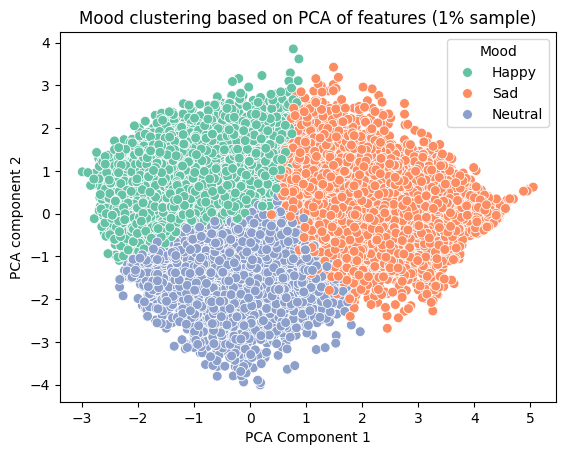

In [19]:
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns

# Predict mood clusters
predictions_mood = kmeans_model.transform(features_df)

# Map mood labels
mood_labels = {0: "Sad", 1: "Happy", 2: "Neutral"}
predictions_mood = predictions_mood.withColumn(
    "mood",
    when(col("mood_score") == 0, "Sad")
    .when(col("mood_score") == 1, "Happy")
    .when(col("mood_score") == 2, "Neutral")
)

# Apply PCA to reduce dimensions to 2 components
pca = PCA(k = 2, inputCol = "features", outputCol = "pca_features")
pca_model = pca.fit(predictions_mood)
predictions_pca = pca_model.transform(predictions_mood)

# Extract PCA components for plotting
def extract_pca_components(pca_col):
    if pca_col and len(pca_col) == 2:
        return [float(pca_col[0]), float(pca_col[1])]
    return [float(0), float(0)]  # Default values in case of issues

extract_pca = udf(extract_pca_components, ArrayType(FloatType()))
predictions_pca = predictions_pca.withColumn("pca_components", extract_pca(col("pca_features")))

# Split PCA components into separate columns
predictions_pca = predictions_pca.withColumn("PCA1", col("pca_components")[0])
predictions_pca = predictions_pca.withColumn("PCA2", col("pca_components")[1])

# Take a radom 1% sample of the data 
sample_df = predictions_pca.sample(withReplacement = False, fraction = 0.01, seed = 42)

# Convert the sampled DataFrame to pandas for plotting 
sample_converted_df = sample_df.select("PCA1", "PCA2", "mood").toPandas()

# Scatter plot for PCA components with mood labels
sns.scatterplot(data = sample_converted_df, x = "PCA1", y= "PCA2", hue = "mood", palette= "Set2", s= 50)
plt.title("Mood clustering based on PCA of features (1% sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA component 2")
plt.legend(title = "Mood")
plt.show()

In [20]:
predictions_pca.cache()

DataFrame[artist_id: string, artist_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, track_id: string, name: string, preview: string, key: double, loudness: double, speechiness: double, liveness: double, instrumentalness: double, valence: double, energy: double, danceability: double, acousticness: double, tempo: double, features: vector, mood_score: int, mood: string, pca_features: vector, pca_components: array<float>, PCA1: float, PCA2: float]

In [21]:
predictions_pca.filter(predictions_pca['artist_name'] == 'Mr.Siro').select('artist_name', 'name', 'mood_score', 'mood').show(truncate = False)

24/12/09 02:39:42 WARN MemoryStore: Not enough space to cache rdd_377_1 in memory! (computed 75.6 MiB so far)
24/12/09 02:39:42 WARN BlockManager: Persisting block rdd_377_1 to disk instead.
24/12/09 02:40:01 WARN MemoryStore: Not enough space to cache rdd_377_2 in memory! (computed 75.8 MiB so far)
24/12/09 02:40:01 WARN BlockManager: Persisting block rdd_377_2 to disk instead.
24/12/09 02:40:20 WARN MemoryStore: Not enough space to cache rdd_377_3 in memory! (computed 75.7 MiB so far)
24/12/09 02:40:20 WARN BlockManager: Persisting block rdd_377_3 to disk instead.


+-----------+-----------------------------------------------------------------+----------+----+
|artist_name|name                                                             |mood_score|mood|
+-----------+-----------------------------------------------------------------+----------+----+
|Mr.Siro    |Trái Tim Em Cũng Biết Đau - Piano Version                        |0         |Sad |
|Mr.Siro    |Em - Piano Version                                               |0         |Sad |
|Mr.Siro    |Sống Xa Anh Chẳng Dễ Dàng - Piano Version                        |0         |Sad |
|Mr.Siro    |Em Đã Sai Vì Em Tin - Piano Version                              |0         |Sad |
|Mr.Siro    |Cánh Đồng Yêu Thương - Piano Version                             |0         |Sad |
|Mr.Siro    |Nguyện Làm Tri Kỷ - Piano Version                                |0         |Sad |
|Mr.Siro    |Mashup 5 Hit Songs In 2017                                       |0         |Sad |
|Mr.Siro    |Người Từng Yêu Anh Rất Sâu 

In [23]:
final_df_mood_genre = predictions_pca
final_df_mood_genre.show(5)

+--------------------+-----------+----------------+---------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+-----+--------------------+--------------------+----------+----------+
|           artist_id|artist_name|          genres|followers|popularity|          link_image|                 url|            track_id|               name|             preview|                 key|            loudness|         speechiness|            liveness|   instrumentalness|            valence|              energy|        danceability|        acousticness|              tempo|            features|mood_score| mood|        pca_features|      pca_components|      PCA1|      PCA2|
+--------------------+------

4. Build recommendation songs by mood and genre

In [32]:
from pyspark.sql.functions import lit

def recommend_songs_by_mood_genre(df, mood, genre, num_recommend = 5):
    # Filter dataFrame by mood and genre
    filtered_tracks = df.filter(
        (col("mood") == lit(mood)) & (F.lower(col("genres")).contains(genre.lower()))
    )
    
    if filtered_tracks.count() == 0:
        print(f"No tracks found with mood {mood} and genre {genre}. Here are some other suggestions:")
        # If no tracks match both mood and genre, recommend random songs from the same mood
        # But if no tracks match with mood, recommend random songs from the same genre
        mood_tracks = df.filter(col("mood") == lit(mood))
        genre_tracks = df.filter(F.lower(col("genres")).contains(genre.lower()))
        
        if mood_tracks.count() == 0:
            print(f"No tracks found with mood. Showing random suggestions by genre {genre}:")
            genre_recommendations = genre_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            genre_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").show(truncate = False)
        else:
            print(f"No tracks found with genre. Showing random suggesstions by mood {mood}:")
            mood_recommendations = mood_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            mood_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").show(truncate = False)
        return

    recommendations = filtered_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
    
    print(f"Recommendations songs with mood {mood} and genre {genre}:")
    recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").distinct().show(truncate = False)

24/12/09 02:28:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

In [37]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Sad", "vietnamese melodic", 5)

24/12/08 15:18:13 WARN MemoryStore: Not enough space to cache rdd_671_1 in memory! (computed 36.4 MiB so far)
24/12/08 15:18:15 WARN MemoryStore: Not enough space to cache rdd_671_2 in memory! (computed 36.7 MiB so far)


Recommendations songs with mood Sad and genre vietnamese melodic:


24/12/08 15:18:18 WARN MemoryStore: Not enough space to cache rdd_671_1 in memory! (computed 36.4 MiB so far)
24/12/08 15:18:19 WARN MemoryStore: Not enough space to cache rdd_671_2 in memory! (computed 36.7 MiB so far)


+-----------+-----------------------------------------+----------------------+----+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|artist_name|name                                     |genres                |mood|popularity|link_image                                                      |url                                                   |preview|
+-----------+-----------------------------------------+----------------------+----+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|tlinh      |ghệ iu dấu của em ơi - Headie remix      |vietnamese melodic rap|Sad |67        |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87da1d85d0445|https://open.spotify.com/artist/3diftVOq7aEIebXKkC34oR|null   |
|tlinh      |ghệ iu dấu của em ơi - Smokele Remix     |vietnamese melodic rap|Sad |67        |https://i.scdn

In [38]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Neutral", "v-pop", 5)

24/12/08 15:18:26 WARN MemoryStore: Not enough space to cache rdd_671_1 in memory! (computed 36.4 MiB so far)
24/12/08 15:18:27 WARN MemoryStore: Not enough space to cache rdd_671_2 in memory! (computed 36.7 MiB so far)


Recommendations songs with mood Neutral and genre v-pop:


24/12/08 15:18:29 WARN MemoryStore: Not enough space to cache rdd_671_1 in memory! (computed 36.4 MiB so far)
24/12/08 15:18:30 WARN MemoryStore: Not enough space to cache rdd_671_2 in memory! (computed 36.7 MiB so far)


+-----------+--------------------------------+------+-------+----------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|artist_name|name                            |genres|mood   |popularity|link_image                                                      |url                                                   |preview                                                                                                    |
+-----------+--------------------------------+------+-------+----------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|HIEUTHUHAI |Exit Sign                       |v-pop |Neutral|70        |https://i.scdn.co/image/a

In [47]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Happy", "vietnamese", 5)

24/12/08 02:57:20 WARN MemoryStore: Not enough space to cache rdd_522_1 in memory! (computed 38.9 MiB so far)
24/12/08 02:57:20 WARN MemoryStore: Not enough space to cache rdd_522_2 in memory! (computed 39.2 MiB so far)


Recommendations songs with mood Happy and genre vietnamese:


24/12/08 02:57:21 WARN MemoryStore: Not enough space to cache rdd_522_1 in memory! (computed 38.9 MiB so far)
24/12/08 02:57:22 WARN MemoryStore: Not enough space to cache rdd_522_2 in memory! (computed 39.2 MiB so far)


+-----------+-----------------------+------------------+-----+----------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|artist_name|name                   |genres            |mood |popularity|link_image                                                      |url                                                   |preview                                                                                                    |
+-----------+-----------------------+------------------+-----+----------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|HIEUTHUHAI |Siêu Sao               |vietnamese hip hop|Happy|70        |https://i.scdn.co/ima

In [ ]:
#lastly, save data into snowflake
snowflake_connection_options = {
    "sfURL": "https://sl70006.southeast-asia.azure.snowflakecomputing.com",
    "sfUser": "HUYNHTHUAN", 
    "sfPassword": "Thuan123456",
    "sfWarehouse": "COMPUTE_WH",
    "sfDatabase": "SPOTIFY_RCM_DB" 
}

final_df_mood_genre = final_df_mood_genre.select("artist_name", "name", "genres", "mood", "followers", "popularity", "link_image", "url", "preview")
final_df_mood_genre.write.format("snowflake") \
        .options(**snowflake_connection_options) \
        .option("dbtable", "SPOTIFY_RCM_SCHEMA.RCM_MOOD_GENRES_TABLE") \
        .mode('overwrite') \
        .save()


24/12/09 02:52:18 WARN MemoryStore: Not enough space to cache rdd_377_1 in memory! (computed 38.9 MiB so far)
24/12/09 02:53:53 WARN MemoryStore: Not enough space to cache rdd_377_2 in memory! (computed 39.2 MiB so far)


In [30]:
spark.stop()

In [43]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = SparkConf()
conf = conf.setAppName("model_spark") \
        .setMaster("local") \
        .set("spark.executor.memory", "4g") \
        .set("spark.executor.cores", "2")

spark = SparkSession.builder.config(conf = conf).getOrCreate()
HDFS_PATH = "hdfs://namenode:9000/datalake/models/rcm_bcf_model/"
data = spark.read.format('parquet').option('header', 'true').load(HDFS_PATH)
data.cache()

24/12/09 17:15:48 WARN MemoryStore: Not enough space to cache rdd_78_3 in memory! (computed 135.3 MiB so far)
24/12/09 17:15:48 WARN BlockManager: Persisting block rdd_78_3 to disk instead.
24/12/09 17:15:49 WARN MemoryStore: Not enough space to cache rdd_78_3 in memory! (computed 135.3 MiB so far)


DataFrame[album_id: string, artist_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, name: string, preview: string, normalized_features: vector]

In [ ]:
# songs = data.filter(data['artist_name'] == "Diddy")
# songs.show()

# songs = songs.rdd.map(lambda row: row.asDict()).collect()
# for row in songs:
#     print(row['name'])

from pyspark.sql.functions import col, lower
from pyspark.sql import Row

# Calculate cosine similarity between the input song and all songs in the dataset
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_v1 = float(v1.norm(2))
    norm_v2 = float(v2.norm(2))
    return dot_product/ (norm_v1 * norm_v2)

def recommend_songs_by_name(song_name, df, top_n = 5):
    # Find all songs having name of song (finding based on key words)
    target_song = df.filter(lower(col("name")).contains(song_name.lower()))
    
    if target_song.count() == 0:
        print(f"Not found the songs matched with {song_name}")
        return None
    
    # Get vector normalized_features of input song
    input_song = df.select("album_id", "name", "normalized_features").first()
    input_song.show()
    
    if input_song is None:
        print(f"Song {song_name} does not exist in dataset")
        return None
    
    input_album_id, input_song_name, input_features = input_song
    
    # Create a list with cosine similarity scores
    similarities = target_song.rdd.map(lambda row: (
        row["album_id"],
        row["name"],
        row["artist_name"],
        row["genres"],
        row["followers"],
        row["popularity"],
        row["link_image"],
        row["url"],
        row['preview'],
        cosine_similarity(input_features, row["normalized_features"]) # apply cosine similarity with normailized features
    ))
    
    # Sort descending by cosine similarity scores
    top_recommendations = similarities.takeOrdered(top_n, key = lambda x : (-x[9], -x[4], -x[5])) # sum of 2 values cosine (genres and features)
    
    # Change list to DataFrame
    recommendations_df = spark.createDataFrame(
        [Row(
            song_name = row[1],
            artist_name = row[2],
            genres = row[3],
            cosine_similarity_score = row[9],
            followers = row[4],
            popularity = row[5],
            link_image = row[6],
            url = row[7],
            preview = row[8] 
        ) for row in top_recommendations]
    )
    
    return recommendations_df

recommend_songs_by_name('my love', data, top_n = 5)

24/12/09 17:23:26 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 135.2 MiB so far)
24/12/09 17:23:26 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 135.3 MiB so far)
24/12/09 17:23:29 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 135.2 MiB so far)
24/12/09 17:23:30 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 135.3 MiB so far)


+--------------------+------------------+-----------+-----------------------+---------+----------+--------------------+--------------------+--------------------+
|           song_name|       artist_name|     genres|cosine_similarity_score|followers|popularity|          link_image|                 url|             preview|
+--------------------+------------------+-----------+-----------------------+---------+----------+--------------------+--------------------+--------------------+
|My Lover (with No...|             Mabel|        pop|      0.999926237149408|  2026903|        64|https://i.scdn.co...|https://open.spot...|                    |
|My Lover - Not3s ...|             Mabel|        pop|      0.999925665276629|  2026903|        64|https://i.scdn.co...|https://open.spot...|                    |
|        Feel My Love|Bathiya & Santhush|sinhala pop|     0.9998960460259808|   293261|        42|https://i.scdn.co...|https://open.spot...|https://p.scdn.co...|
|         ALL MY LOVE|      

24/12/09 17:25:57 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-ce95d9d3-10c4-489a-8627-3784789ee36d. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-ce95d9d3-10c4-489a-8627-3784789ee36d
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:178)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:113)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1231)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach

In [42]:
spark.catalog.clearCache()